# Lab 4-6: Mixture Models+Model order selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before November 21 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
#sns.set_context('poster')
#sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
import time
import sklearn
import math

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [2]:
class my_GMM():
    
    def __init__(self, k, init_strat="random", bin_strat="hard", tol=1e-2, itermax=50):
        '''
        Parameters:
        k: integer
            number of components
        tol: float
            convergence tolerance
        itermax: integer
            maximum iteration value
        init_strat: {"random", "kmeans"}
            whether to use a random initialisation or using kmeans
        bin_strat: {"hard", "soft"}
            whether to draw clusters using argmax or multinoulli
       
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k_ = k
        self.tol_ = tol
        self.itermax_ = itermax
        self.init_strat_ = init_strat
        self.bin_strat_ = bin_strat
        
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
        self.history = {}
        
        
    def get_params(self, deep=True):
        """Get parameters for this estimator. 
        This function will be of help in the cross_validation implementation.
        Parameters
        ----------
        deep : boolean, optional
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.
        """
        out = dict()
        out['k'] = self.k_
        out['tol'] = self.tol_
        out['itermax'] = self.itermax_
        out['init_strat'] = self.init_strat_
        out['bin_strat'] = self.bin_strat_
        return out
        
        
    def gauss_pdf(self, X, mu, Sigma):
        """
        Computes the PDF of a Gaussian distribution of parameters Sigma and mu,
        evaluated in every point of X and every cluster
        
        Parameters:
        -----------
        X: (n, p) np.array
            Points of evaluation
        
        mu: (k, p) np.array
            Estimators of the mean
            
        Sigma: (k, p, p) np.array
            Variance matrix estimators
        
        Returns:
        -----
        (n, k) array: Evaluation of the PDF
        """
        n, p = X.shape
        k,_ = mu.shape
        exp = np.zeros((n, k))
        det = np.zeros((k,))

        Sinv = np.array([np.linalg.inv(Sigma[j]) for j in range(k)])
        Det = np.array([np.linalg.det(Sigma[j]) for j in range(k)])
        Dev = np.array([X-mu[j] for j in range(k)])

        for j in range(k):
            exp[:, j] = np.diag(Dev[j]@Sinv[j]@Dev[j].T)
        return np.exp(
            -0.5 * np.log(2*np.pi*Det + 1e-6)
            -0.5 * exp
        )
    
    def fit_(self, X, alpha0, mu0, Sigma0):
        self.alpha_, self.mu_, self.Sigma_ = alpha0, mu0, Sigma0
        self.has_converged = False
        self.history = {"cpm": [], "alpha": [], "mu": [], "Sigma": []}
        
        itr = 0
        while not self.has_converged and itr < self.itermax_:
            itr += 1
            # E-step: compute conditional probability matrix
            self.cond_prob_ = self.compute_proba(X=X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
            
            self.history["cpm"].append(self.cond_prob_)
            self.history["alpha"].append(self.alpha_)
            self.history["mu"].append(self.mu_)
            self.history["Sigma"].append(self.Sigma_)
            
            # M-step: update parameters estimators
            new_alpha = self.update_alpha(cpm=self.cond_prob_)
            new_mu = self.update_mu(X=X, cpm=self.cond_prob_, alpha=new_alpha)
            new_Sigma = self.update_Sigma(X=X, cpm=self.cond_prob_, alpha=new_alpha, mu=new_mu)
            
            old_params = (self.alpha_, self.mu_, self.Sigma_)
            new_params = (new_alpha, new_mu, new_Sigma)
            
            self.has_converged = self.evaluate_convergence(X, old_params=old_params, new_params=new_params)
            
            self.alpha_ = new_alpha
            self.mu_ = new_mu
            self.Sigma_ = new_Sigma
        
        self.labels_ = self.predict(X, alpha=self.alpha_, mu=self.mu_, Sigma=self.Sigma_)
        return self
        
        
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """    
        
        # Initialize parameters estimators
        init_params = self.init_params(X, self.k_)
        
        return self.fit_(X, *init_params)
        
    def predict(self, X, alpha, mu, Sigma):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """ 
        n= X.shape[0]
        cpm = self.compute_proba(X=X, alpha=alpha, mu=mu, Sigma=Sigma)
        if self.bin_strat_=='hard':
            labels = np.argmax(cpm, axis=1)
        elif self.bin_strat_=='soft':
            labels = np.array([np.argmax(np.random.multinomial(1, cpm[k]/np.sum(cpm[k]))) for k in range(n)])
        else:
            raise ValueError
        return labels
    
    def evaluate_convergence(self, X, old_params, new_params):
        """Returns wether the algorithm has converged
        """
        return abs(self.log_likelihood(X, *old_params) - self.log_likelihood(X, *new_params)) <= self.tol_
        
    def compute_proba(self, X, alpha, mu, Sigma):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n, p = X.shape
        k = self.k_
        alpha = alpha.reshape(-1,1)
        PDFs = self.gauss_pdf(X, mu, Sigma)
        cpm = np.exp(
            np.log(np.repeat(alpha.T, n, axis=0) + 1e-6) 
            + np.log(PDFs + 1e-6)
            - np.log(np.repeat(PDFs@alpha, k, axis=1) + 1e-6)
        )
        return cpm
    
    def init_params(self, X, K):
        """Initialize parameters estimators
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        K: int
            Number of classes / clusters
        
        Returns:
        -----
        ((k,) np.array, (k, p) np.array, (k, p, p) np.array) tuple
            Tuple of 3 np.arrays: (alpha0, mu0, Sigma0)
        """        
        n = X.shape[0]
        p = X.shape[1]
        
        from sklearn.cluster import KMeans
        k_means = KMeans(n_clusters=K).fit(X)
        X_labels = k_means.labels_
        
        mu0 = k_means.cluster_centers_
        Sigma0 = []
        alpha0 = []
        
        for k, count in zip(*np.unique(X_labels, return_counts=True)):
            X_k = np.array([X[i] for i in range(n) if X_labels[i] == k])
            Sigma0.append(np.cov(X_k.T) + 1e-3 * np.eye(p))
            alpha0.append(count/n)
        Sigma0 = np.array(Sigma0)
        alpha0 = np.array(alpha0)
        
        return (alpha0, mu0, Sigma0)
    
    def update_alpha(self, cpm):
        """Returns the updated version of alpha (cluster proportion estimators)
        
        Parameters:
        -----------
        cpm: (n, k) np.array
            Conditional probability matrix

        Returns:
        -----
        (k,) np.array
            The new estimators for cluster proportion
        """
        new_alpha = np.mean(cpm, axis=0)
        return new_alpha
    
    def update_mu(self, X, cpm, alpha):
        """Returns the updated version of mu (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        Returns:
        -----
        (k, p) np.array
            The new estimators for clusters' means
        """
        n = X.shape[0]
        k = cpm.shape[1]   
        p = X.shape[1]
        new_mu = cpm.T@X
        np.divide(new_mu, np.repeat(n * alpha.reshape(-1,1), p, axis=1), out=new_mu)
        return new_mu

    def update_Sigma(self, X, cpm, alpha, mu):
        """Returns the updated version of Sigma (cluster mean estimators)
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        cpm: (n, k) np.array
            Conditional probability matrix
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
        
        Returns:
        -----
        (k, p, p) np.array
            The new estimators for clusters' variances
        """
        n = X.shape[0]
        k = cpm.shape[1]
        p = X.shape[1]
        
        new_Sigma = np.zeros(shape=(k, p, p))
        
        for j in range(k):
            dev = X - mu[j]
            c_dev = np.multiply(np.repeat(cpm[:,j].reshape(-1,1), p, axis=1), dev)
            new_Sigma[j] = (c_dev.T @ dev) / (n * alpha[j])
        return new_Sigma
    
    def log_likelihood(self, X, alpha, mu, Sigma):
        """Returns whether the algorithm has converged
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data
        
        alpha: (k, ) np.array
            Current estimators for the clusters' proportions
        
        mu: (k, p) np.array
            Current estimators for the clusters' means
            
        Sigma: (k, p, p) np.array
            Current estimators for clusters' variances
        
        Returns:
        -----
        float
            log-likelihood for the given parameters
        """
        l = 0
        n = X.shape[0]
        k = alpha.shape[0]
        alpha = alpha.reshape(-1,1)
        PDFs = self.gauss_pdf(X, mu, Sigma)
        return np.ones((1,n))@(PDFs@alpha)

Let's generate our own mixture of Gaussian distributions to test the model. We will choose parameters so that GMM performs better than K-Means on it. We use `np.random.multivariate_normal`. 

We will not plot data with colors representing predicted labels and shapes representing real labels. Instead, we will match the colors and plot both the predictions and the ground truth.

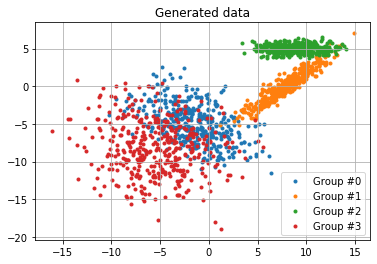

In [14]:
X = []

for _ in range(4):
    mu = np.random.uniform(-10,10, (2,))
    sigma = np.random.uniform(-3,3, (2,2))
    sigma = sigma.T@sigma
    pts = []
    for _ in range(400):
        pts.append(np.random.multivariate_normal(mean=mu, cov=sigma))
    X.append(np.array(pts))

for i, pts in enumerate(X):
    plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i))
plt.legend()
plt.title('Generated data')
plt.grid()
plt.show()

In [15]:
# As X is built cluster by cluster : 
#              X = [[Cluster1], [Cluster2], [Cluster3], [Cluster4]]
# we create an array containing all data and not lists of data : 
#           data = array([Cluster1, Cluster2, Cluster3, Cluster4])
data = np.concatenate(X)

In [16]:
gmm = my_GMM(k=4, bin_strat="soft") 
# Uncomment this if you want to use a multinoulli instead of argmax to make the decision.
start = time.time()
gmm.fit(data)
end = time.time()
print("Has converged:", gmm.has_converged, "exec time {:.2f} ms".format((end-start)*1e3))

Has converged: [[ True]] exec time 1043.27 ms


>Our implementation is pretty fast thanks to all computations done using arrays and numpy operations ! Which tackles its readability though...

Then, we implement an accuracy metric and a mapping to plot the proper colors for each cluster and easily compare the results to the ground truth :

In [51]:
def gmm_accuracy_mapping(X, gmm):
    """
    Computes the accuracy of our model and also returns the mapping of the labels.
    It aims at mapping the guessed cluster with it's ground truth, maximizing the accuracy.
    """
    acc = 0
    mapping = {}
    data = np.concatenate(X)
    gmm_labels = gmm.predict(data, gmm.alpha_, gmm.mu_, gmm.Sigma_)
    
    if len(X)==np.unique(gmm_labels).shape[0]:
        associated = {}
        reverse_mapping = {}
        for gmm_label in np.unique(gmm_labels):
            data_cluster = np.array([data[j] for j in range(data.shape[0]) if gmm_labels[j] == gmm_label])

            search_count = np.array([0 for true_label in range(len(X))])
            for pt in data_cluster:
                for true_label in range(len(X)):
                    search_count[true_label] += 1 if pt in X[true_label] else 0
            
            while True:
                prediction = np.argmax(search_count)
                concerned_pts = search_count[prediction]
                if prediction not in associated.keys():
                    associated[prediction] = concerned_pts
                    mapping[gmm_label] = prediction
                    reverse_mapping[prediction] = (gmm_label, search_count)
                    break
                elif associated[prediction] < concerned_pts:
                    old_gmm_label, old_search_count = reverse_mapping[prediction]
                    old_search_count[prediction] = -1
                    new_old_prediction = np.argmax(old_search_count)
                    associated[new_old_prediction] = old_search_count[new_old_prediction]
                    mapping[old_gmm_label] = new_old_prediction
                    reverse_mapping[new_old_prediction] = (old_gmm_label, old_search_count)
                    
                    associated[prediction] = concerned_pts
                    mapping[gmm_label] = prediction
                    reverse_mapping[prediction] = (gmm_label, search_count)
                    break
                else:
                    search_count[prediction] = -1

        acc = np.sum(list(associated.values()))
        acc /= float(len(gmm_labels))

        return acc, mapping
    
    else:
        if len(X) < len(np.unique(gmm_labels)):
            mapping = {k:len(np.unique(gmm_labels)) - 1 for k in range(len(np.unique(gmm_labels)))}
        reverse_mapping = {}
        pts_concerned = {k:0 for k in range(len(X))}
        
        for gmm_label in np.unique(gmm_labels):
            data_cluster = np.array([data[j] for j in range(data.shape[0]) if gmm_labels[j] == gmm_label])

            search_count = np.array([0 for true_label in range(len(X))])
            for pt in data_cluster:
                for true_label in range(len(X)):
                    search_count[true_label] += 1 if pt in X[true_label] else 0
            true_label = np.argmax(search_count)
            if true_label not in mapping.values():
                mapping[gmm_label] = true_label # map the gmm_label to the true_label
                reverse_mapping[true_label] = gmm_label # record the reverse link
                pts_concerned[true_label] = search_count[true_label] # memory of the number of points concerned by this mapping
            
            elif search_count[true_label] > pts_concerned[true_label]:
                mapping[reverse_mapping[true_label]] = len(np.unique(gmm_labels)) - 1 # assign the old one back to its original value
                mapping[gmm_label] = true_label # map the gmm_label to the true_label
                reverse_mapping[true_label] = gmm_label # record the reverse link
                pts_concerned[true_label] = search_count[true_label] # memory of the number of points concerned by this mapping
        
        acc = np.sum(list(pts_concerned.values()))
        acc /= float(len(gmm_labels))
        
        idx = 1
        for cluster in mapping.keys():
            if mapping[cluster] >= len(X):
                mapping[cluster] = len(np.unique(gmm_labels)) - idx
                idx += 1

        return acc, mapping

In [18]:
def visualize_gmm(X, gmm1, title1, gmm2=None, title2=''):
    """
    Function to plot the ground truth and the method of mixture models. 
    It aims at plotting the same colors for corresponding clusters.
    """
    data = np.concatenate(X)
    
    plt.figure(figsize=(16,4))

    plt.subplot(121)
    acc1, mapping1 = gmm_accuracy_mapping(X, gmm1)
    for label in np.unique(list(mapping1.values())):
        data_i = np.array([data[j] for j in range(data.shape[0]) if mapping1[gmm1.labels_[j]] == label])
        plt.scatter(data_i.T[0], data_i.T[1], marker='.', label="Cluster #{}".format(label), alpha=0.5)
    plt.title(title1 + '\naccuracy = {}'.format(acc1))
    plt.legend()
    plt.grid()

    plt.subplot(122)
    if gmm2==None:
        for i, pts in enumerate(X):
            plt.scatter(pts.T[0], pts.T[1], marker='.', label="Group #{}".format(i), alpha=0.5)
        plt.title('Ground truth')
    else:
        acc2, mapping2 = gmm_accuracy_mapping(X, gmm2)
        for label in np.unique(list(mapping2.values())):
            data_i = np.array([data[j] for j in range(data.shape[0]) if mapping2[gmm2.labels_[j]] == label])
            plt.scatter(data_i.T[0], data_i.T[1], marker='.', label="Cluster #{}".format(label), alpha=0.5)
        plt.title(title2 + '\naccuracy = {}'.format(acc2))
    plt.legend()
    plt.grid()
    plt.show()

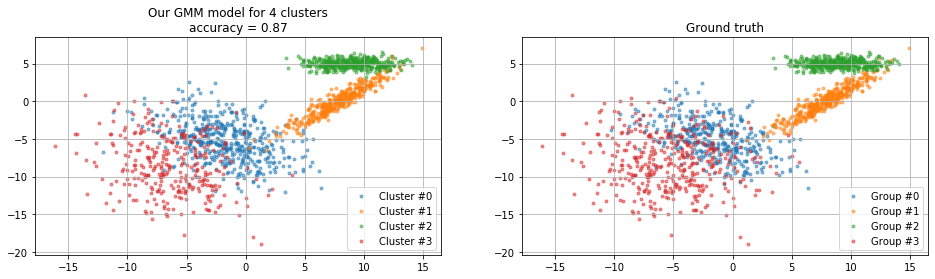

In [19]:
visualize_gmm(X, gmm, 'Our GMM model for 4 clusters')

>It works impressively well ! Note that using a decision based on multinoulli improves the plotting and seems clearcly better, but it reduces the accuracy...

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

---

### Second Part
 
- Implement the information criterions from the lecture (AIC, BIC, etc.) to select the number of clusters:

### AIC & BIC

In [33]:
def AIC(C, X):
    """
    returns a tuple (model, AIC_value)
    """
    gmm = my_GMM(k=C)
    gmm.fit(X)
    # Compute the number of parameters of our model :
    p = X.shape[1]
    M = C * (1 + p + p*(p+1)/2) - 1 
    # because the Cth element of alpha is deduced by the others, and sigma is symmetric
    return gmm, gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_) - M

def BIC(C, X):
    """
    returns a tuple (model, BIC_value)
    """
    gmm = my_GMM(k=C)
    gmm.fit(X)
    # Compute the number of parameters of our model :
    N = X.shape[0]
    p = X.shape[1]
    M = C * (1 + p + p*(p+1)/2) - 1 
    # because the Cth element of alpha is deduced by the others, and sigma is symmetric 
    return gmm, gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_) - M*N/2

In [34]:
AIC_scores = []
BIC_scores = []
very_beg = time.time()
for C in range(1,8):
    begin = time.time()
    AIC_scores.append(AIC(C, data)[1][0,0])
    stop = time.time()
    BIC_scores.append(BIC(C, data)[1][0,0])
    print("AIC, M={} takes {} seconds to converge.".format(C,stop-begin))
very_end = time.time()
print('-'*50)
print("AIC, in total it takes {} seconds to execute.".format(C,very_end-very_beg))

AIC, M=1 takes 0.06003832817077637 seconds to converge.
AIC, M=2 takes 0.24718594551086426 seconds to converge.
AIC, M=3 takes 0.39009785652160645 seconds to converge.
AIC, M=4 takes 0.750497579574585 seconds to converge.
AIC, M=5 takes 0.9934158325195312 seconds to converge.
AIC, M=6 takes 1.5448601245880127 seconds to converge.
AIC, M=7 takes 2.7811238765716553 seconds to converge.
--------------------------------------------------
AIC, in total it takes 7 seconds to execute.


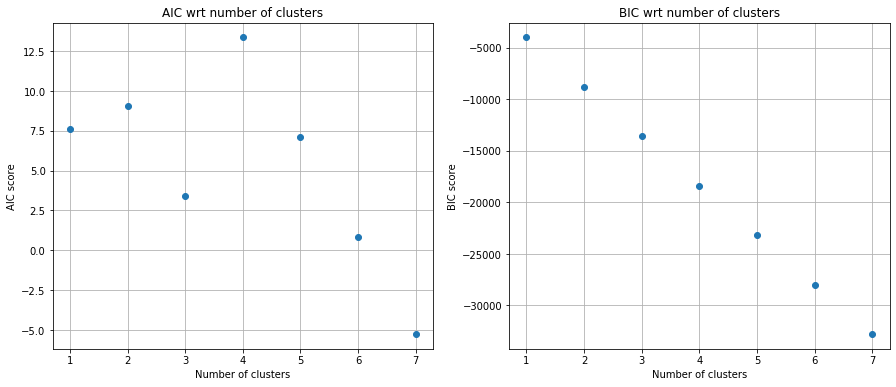

In [35]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(range(1,8), AIC_scores, linestyle='', marker='o')
plt.title('AIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('AIC score')
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1,8), BIC_scores, linestyle='', marker='o')
plt.title('BIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC score')
plt.grid()

plt.show()

We then take the argmax of the scores to get the correct value for our parameter N :

In [36]:
optimal_AIC = np.argmax(AIC_scores)+1
print("According to the AIC criterion, the optimal value for M is", optimal_AIC)
optimal_BIC = np.argmax(BIC_scores)+1
print("According to the BIC criterion, the optimal value for M is", optimal_BIC)

According to the AIC criterion, the optimal value for M is 4
According to the BIC criterion, the optimal value for M is 1


And now let's plot the clusters according to the best parameter we just obtained :

<Figure size 1152x288 with 0 Axes>

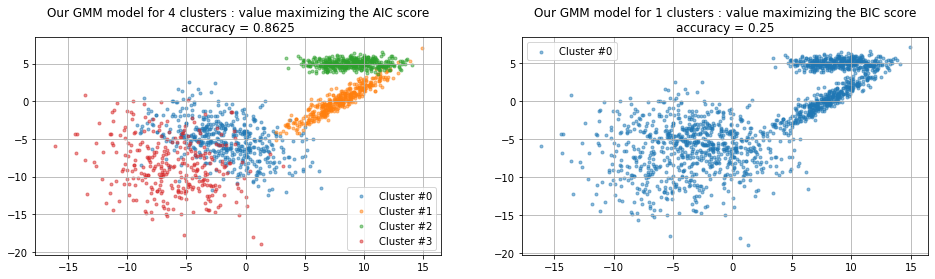

In [37]:
plt.figure(figsize=(16,4))

best_aic_gmm = my_GMM(k=optimal_AIC, bin_strat='soft')
best_aic_gmm.fit(data)
best_bic_gmm = my_GMM(k=optimal_BIC)
best_bic_gmm.fit(data)

visualize_gmm(X, gmm1=best_aic_gmm, gmm2=best_bic_gmm, 
              title1='Our GMM model for {} clusters : value maximizing the AIC score'.format(optimal_AIC), 
              title2='Our GMM model for {} clusters : value maximizing the BIC score'.format(optimal_BIC))

**Observation :**
- The AIC score is pretty good but doesn't always yield the value we want.
- The BIC score seems to be too aggressive and thus always find 1 as the optimal value to maximize it...


*Let's explore new ways of finding the best number of clusters parameter !*

>AIC is the best of both techniques and computes in **~7seconds**.

### Merge criterions

Another approach for selecting the right number of clusters is to start with a big number of clusters, and then iteratively merge pairs of clusters, based on some criterion.

We will explore several of those criterions and empirically compare their performances.

In [26]:
def merge(merge_1, merge_2, X, gmm):
    """Returns initialisation parameters to merge cluster merge_1 and cluster merge_2.
    
    Arguments:
    ----------
    merge_1: int
        Index of the first cluster to merge
    merge_2: int
        Index of the second cluster to merge
    X: (n, p) np.array
        Data on which we learn the model
    gmm: my_GMM instance
        GMM model instance, trained on X
    
    Returns:
    --------
    (alpha, mu, Sigma, k): Initialisation to pass to a new GMM model, merging clusters merge_1 and merge_2
    """
    cpm = gmm.cond_prob_
    alpha = gmm.alpha_
    mu = gmm.mu_
    Sigma = gmm.Sigma_
    # Update the cpm matrix
    cpm[:,merge_1] = cpm[:,merge_1] + cpm[:,merge_2]
    cpm = np.delete(cpm, merge_2, axis=1)
    # Update alpha
    alpha[merge_1] = alpha[merge_1] + alpha[merge_2]
    alpha = np.delete(alpha, merge_2)
    # Update mu
    mu = gmm.update_mu(X, cpm, alpha)
    # Update Sigma
    Sigma = gmm.update_Sigma(X, cpm, alpha, mu)
    
    k = gmm.k_ - 1
    
    return alpha, mu, Sigma, k

#### Correlation coeffictients

This criterion computes the correlation coefficients between two column vectors of the conditional probability matrix and merges the clusters that have the greatest correlation. We repeat the merge process until the clusters are not positively correlated anymore. This is a strong assumption over the data distribution, at first we implemented this approach using a threshold, but it adds a hyperparameter which was very difficult to tune.

In [27]:
def correlation_coefficients(X, C_max=None, bin_strat="hard"):
    """
    Return the good number of clusters according to a low inter-cluster correlation criterion.
    """
    if C_max == None:
        C_max = X.shape[0]
    
    ### First, we train a GMM with C_max clusters on the data
    gmm = my_GMM(k=C_max, bin_strat=bin_strat)
    gmm.fit(X)
    alpha = gmm.alpha_
    mu = gmm.mu_
    Sigma = gmm.Sigma_
    history = {'alpha':[alpha], 'mu':[mu], 'Sigma':[Sigma], 
               'log_likelihood':[gmm.log_likelihood(X, alpha, mu, Sigma)]}
    
    ### Then, we iteratively merge the two most correlated clusters
    converged = False
    while not converged and gmm.k_ > 1:
        ### Compute the highest correlation between clusters
        coefs = np.triu(np.corrcoef(gmm.cond_prob_, rowvar=False), 1)
        corr = np.amax(coefs)
        
        if np.isnan(corr) or corr <= 0:
            ### If coefficients are not correlated, stop the iteration and return
            converged = True
        else:
            ### Merge the two clusters and update the model
            merge_1, merge_2 = list(zip(*np.where(coefs == corr)))[0]
            alpha, mu, Sigma, k = merge(merge_1, merge_2, X, gmm)
            gmm.k_ = k
            gmm.fit_(X, alpha, mu, Sigma)
            
            ### Keep track of the parameters and log_likelihood
            history['alpha'].append(gmm.alpha_)
            history['mu'].append(gmm.mu_)
            history['Sigma'].append(gmm.Sigma_)
            history['log_likelihood'].append(gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_))

    return gmm, history

In [28]:
start = time.time()
model_best_corr, history = correlation_coefficients(X=data, C_max=10, bin_strat='soft')
end = time.time()
print("Final number of clusters:", model_best_corr.k_)
print("Execution time: {:.3f} s".format(end-start))

Final number of clusters: 4
Execution time: 12.848 s


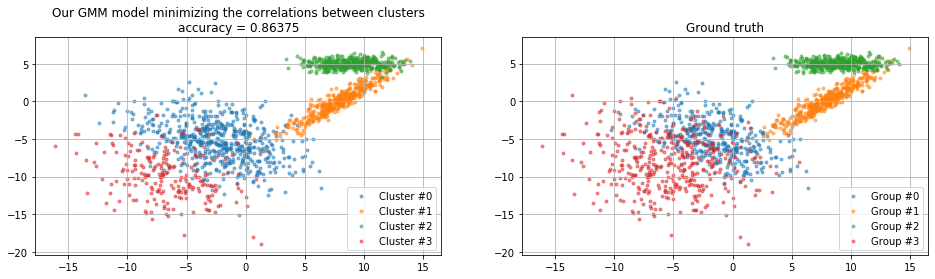

In [29]:
visualize_gmm(X, model_best_corr, 'Our GMM model minimizing the correlations between clusters')

>The criterion works great at retreiving the right number of clusters, and it's accuracy score is very close to what we achieved with a 4-cluster GMM in part 1. It takes **~13 seconds** to execute which is still pretty slow.

#### Measuring error

We could also merge clusters if doing so maximizes the likelihood of the whole model.

In [30]:
def measuring_error(X, C_max=None, bin_strat='hard'):
    """
    Merges of clusters according to a high likelihood criterion.
    """
    if C_max == None:
        C_max = X.shape[0]
    
    ### First, let's create the clusters using the value of C_max
    gmm = my_GMM(k=C_max, bin_strat=bin_strat)
    gmm.fit(X)
    history = gmm.history
    history['log_likelihood'] = [gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_)]
    
    ### Then, let's merge the clusters if it increases the likelihood
    best_gmm = gmm
    converged = False
    while not converged and gmm.k_ > 1:
        
        old_lieklihood = history['log_likelihood'][-1]
        best_lieklihood = history['log_likelihood'][-1]
        
        ### iteratively select two clusters and compute the potential new likelihood if we merge them
        for merge_1 in range(1, gmm.k_):
            for merge_2 in range(merge_1):
                new_alpha, new_mu, new_Sigma, new_k = merge(merge_1, merge_2, X, gmm)
                new_gmm = my_GMM(k=new_k, bin_strat=bin_strat)
                new_gmm.fit_(X, new_alpha, new_mu, new_Sigma)
                new_likelihood = new_gmm.log_likelihood(X, new_gmm.alpha_, new_gmm.mu_, new_gmm.Sigma_)
                if new_likelihood >= best_lieklihood: 
                    # Having the same likelihood with less clusters is better, hence we merge in the '=' case.
                    best_lieklihood = new_likelihood
                    best_gmm = new_gmm
        
        ### Store the best model for the next iteration
        gmm = best_gmm
        
        ### If likelihood is not improved, return
        if best_lieklihood==old_lieklihood:
            converged = True
        else:
            # Update gmm
            # Keep track of the values
            history['alpha'].append(best_gmm.alpha_)
            history['mu'].append(best_gmm.mu_)
            history['Sigma'].append(best_gmm.Sigma_)
            history['log_likelihood'].append(best_lieklihood)
            
    return gmm, history

In [31]:
start = time.time()
model_best_like, history = measuring_error(X=data, C_max=8, bin_strat='soft')
end = time.time()
print("Final number of clusters:", model_best_like.k_)
print("Execution time: {:.3f} s".format(end-start))

Final number of clusters: 7
Execution time: 179.594 s


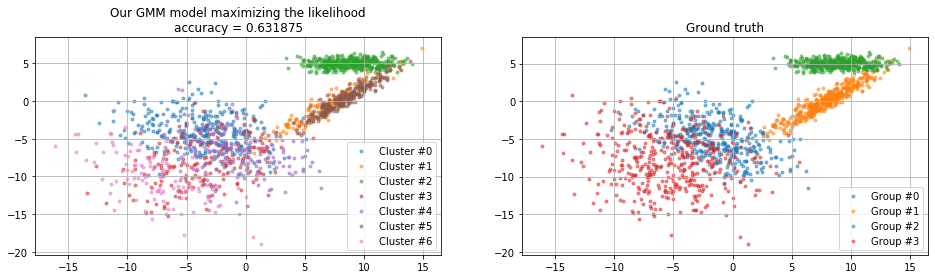

In [32]:
visualize_gmm(X, model_best_like, 'Our GMM model maximizing the likelihood')

> This method is pretty good but it is not as robust as the previous one. Compared to the previous one, it doesn't work very well as is shown on the graph. It stands to reason that the 6th cluster shouldn't be there for instance... It also takes **~180 seconds** to compute which is the highest execution time that far. We think that those bad results come from the fact that we might be stuck in a local maxima of the likelihood. Indeed as it has local maxima, the algorithm may not converge.

#### Comparing the parameters

Another approach is to compare the probability densities of the gaussians, and merge them if they are close enough.

One way to compare two probability densities is the Wasserstein distance, which derives in the case of gaussians into:

$$W(n_1,n_2)^2 = \|\mu_1 - \mu_2\|^2 + trace(\Sigma_1 + \Sigma_2 - 2(\Sigma_2^{\frac{1}{2}}\Sigma_1\Sigma_2^{\frac{1}{2}})^{\frac{1}{2}})$$

Where:

$n_1 \sim N(\mu_1, \Sigma_1)$

$n_2 \sim N(\mu_2, \Sigma_2$

We can implement an algorithm that merges the two closest clusters (according to Wasserstein distance) if it increases the likelihood of the model.

In [38]:
from scipy.linalg import fractional_matrix_power as fp

def square_wasserstein(mu1, Sigma1, mu2, Sigma2):    
    return (mu1-mu2).T@(mu1-mu2) + np.trace(Sigma1 + Sigma2 - 2*fp(fp(Sigma2, 0.5)@Sigma1@fp(Sigma2, 0.5), 0.5))

In [39]:
def compute_distances(gmm):
    params = [(gmm.mu_[j], gmm.Sigma_[j]) for j in range(gmm.k_)]
    distances = np.triu(np.array([[square_wasserstein(*params[i], *params[j]) for i in range(gmm.k_)] for j in range(i)]), 1)
    dmin = np.amin(distances[np.where(distances > 1e-7)])
    return dmin, distances

In [40]:
def AIC_score(gmm, X):
    """
    returns a tuple (model, AIC_value)
    """
    C = gmm.k_
    # Compute the number of parameters of our model :
    p = X.shape[1]
    M = C * (1 + p + p*(p+1)/2) - 1 
    # because the Cth element of alpha is deduced by the others, and sigma is symmetric
    return gmm.log_likelihood(X, gmm.alpha_, gmm.mu_, gmm.Sigma_) - M

In [55]:
def compare_params(X, C_max=None, scoring="aic", thresh=None):
    """
    Return the good number of clusters by merging the ones having similar mu and Sigma.
    """
    if C_max == None:
        C_max = X.shape[0]
    
    ### First, let's create the clusters using the value of C_max
    gmm = my_GMM(k=C_max)
    gmm.fit(X)
    alpha = gmm.alpha_
    mu = gmm.mu_
    Sigma = gmm.Sigma_
    
    dmin, distances = compute_distances(gmm)
    
    if scoring=="like":
        new_score = gmm.log_likelihood(X, alpha, mu, Sigma)

    elif scoring=="aic":
        new_score = AIC_score(gmm, X)

    elif scoring=='dist':
        new_score = dmin / distances.sum()
        
    history = {'alpha':[alpha], 'mu':[mu], 'Sigma':[Sigma], 'score':[new_score]}
    
    ### Then, let's merge the clusters if it increases the likelihood
    converged = False
    while not converged and gmm.k_ > 3:
        ### Compute the smallest non-zero distance between clusters        
        
        ### Merge the two clusters if it improves the likelihood
        merge_1, merge_2 = list(zip(*np.where(distances == dmin)))[0]
        
        new_alpha, new_mu, new_Sigma, new_k = merge(merge_1, merge_2, X, gmm)
        new_gmm = my_GMM(k=new_k)
        new_gmm.fit_(X, new_alpha, new_mu, new_Sigma)
        
        new_dmin, distances = compute_distances(new_gmm)
        
        old_score = history['score'][-1]
        
        if scoring=="like":
            new_score = new_gmm.log_likelihood(X, new_gmm.alpha_, new_gmm.mu_, new_gmm.Sigma_)
            stop = new_score < old_score
            
        elif scoring=="aic":
            new_score = AIC_score(gmm, X)
            stop = new_score < old_score
            
        elif scoring=='dist':
            new_score = new_dmin / distances.sum()
            stop = new_score > thresh
        
        print('old_score = {} | new_score = {}'.format(old_score, new_score))
        
        if stop:
            converged = True
        else:
            dmin = new_dmin
            gmm = new_gmm

            ### Keep track of the parameters and log_likelihood
            history['alpha'].append(gmm.alpha_)
            history['mu'].append(gmm.mu_)
            history['Sigma'].append(gmm.Sigma_)
            history['score'].append(new_score)

    return gmm, history

In [63]:
start = time.time()
model_best_params, history = compare_params(X=data, C_max=10, scoring="dist", thresh=.015)
end = time.time()
print("Final number of clusters:", model_best_params.k_)
print("Execution time: {:.3f} s".format(end-start))

old_score = 0.0018898615920377193 | new_score = 0.0020995184896620426
old_score = 0.0020995184896620426 | new_score = 0.003069170703612383
old_score = 0.003069170703612383 | new_score = 0.007142432978012234
old_score = 0.007142432978012234 | new_score = 0.011613926269911555
old_score = 0.011613926269911555 | new_score = 0.016915579509420183
Final number of clusters: 6
Execution time: 13.324 s


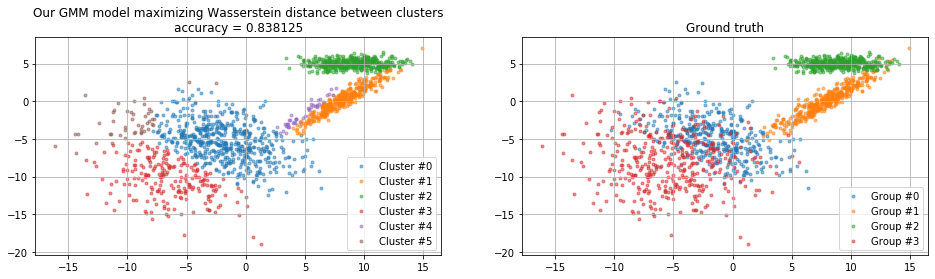

In [64]:
visualize_gmm(X, model_best_params, 'Our GMM model maximizing Wasserstein distance between clusters')

>This method really doesn't work well. We have tried some tricks using the wassertstein distance but :
- we think that our stopping criterion **best likelihood** isn't a good one... as the likelihood has local maxima or is really weird. It executes in **~9 seconds** but as it doesn't converge this shouldn't be taken into account.
- when replacing this criterion by **best AIC** it doesn't perform very well neither, even though AIC seems to be a more robust criterion. It executes in **~12 seconds**.
- the best stopping criterion seems to be a threshold over the maximal distance between two clusters to merge them. However, this adds a hyperparameter that is very hard to make robust to the dataset. It executes in **~13 seconds**.

>Or perhaps the approach isn't good itself ? The execution time is also not comparable to the other methods because of the early stopping of the algorithm.

### Cross-validation 

Finally, a common approach to model selection is cross-validation.

The idea is to keep the model that has the best and most consistent behaviour on new (unseen during training) data, that is, the model that has the best performances while not overfitting.

The train dataset is split severeal times in a proper train set (on which we'll learn the model) and a validation set (on which we evaluate the model's performances).

Then we choose the model that has the best cross-validation score across all the train-validation sets.

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

def scoring(est, cross_data):
    # need to reconstruct the original X using the splitted data
    orginal_data_format = [[] for index in range(len(X))]
    for elt in cross_data:
        for index, orig_set in enumerate(X):
            if elt in orig_set:
                orginal_data_format[index].append(list(elt))
    for index in range(len(orginal_data_format)):
        orginal_data_format[index] = np.array(orginal_data_format[index])
    return gmm_accuracy_mapping(orginal_data_format, est)[0]

def cross_val(data, C_max):
    # need to shuffle the data first :
    data = shuffle(data)
    res = {}
    for n_clusters in range(1,C_max):
        gmm = my_GMM(k=n_clusters)
        res[n_clusters] = (cross_val_score(estimator=gmm, X=data, scoring=scoring, cv=3),
                           gmm)
    return res

In [66]:
def cross_validation(X, C_max=10):
    res = cross_val(data=X, C_max=C_max)
    best_acc = 0
    best_model = None
    for n_clusters in res.keys():
        acc = np.mean(res[n_clusters][0])
        if acc > best_acc:
            best_acc = acc
            best_model = res[n_clusters][1]
    best_model.fit(X)
    return best_model, best_acc

In [67]:
start = time.time()
best_model_cv, best_acc = cross_validation(data, 10)
end = time.time()
print("Number of clusters of the best model:", best_model_cv.k_)
print("Execution time: {:.3f} s".format(end-start))

Number of clusters of the best model: 5
Execution time: 23.419 s


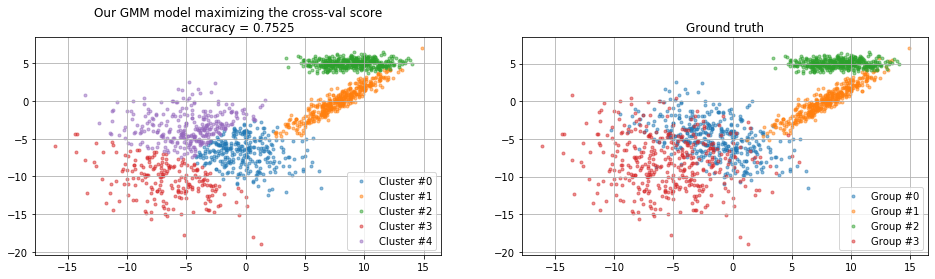

In [68]:
visualize_gmm(X, best_model_cv, 'Our GMM model maximizing the cross-val score')

>This is a very good approach which yields promising results. The function executes in **~23 seconds** which is acceptable. However it needs a score to assess the performance which may be a major issue in the following case...

---

# Conclusion

Use the model selection criterions to choose the number of clusters for the two given datasets (data-MM-i.csv). Compare the results and the computational time. Try to visually validate your results.

### Load the data

In [69]:
import pandas as pd
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

data_1 = pd.read_csv('data_MM_1.csv', header=None).values
data_2 = pd.read_csv('data_MM_2.csv', header=None).values

# In order to visualize it, we will compute a PCA to reduce the dimension to 2
data_1_2d = PCA(n_components=2).fit_transform(data_1)
data_2_2d = PCA(n_components=2).fit_transform(data_2)

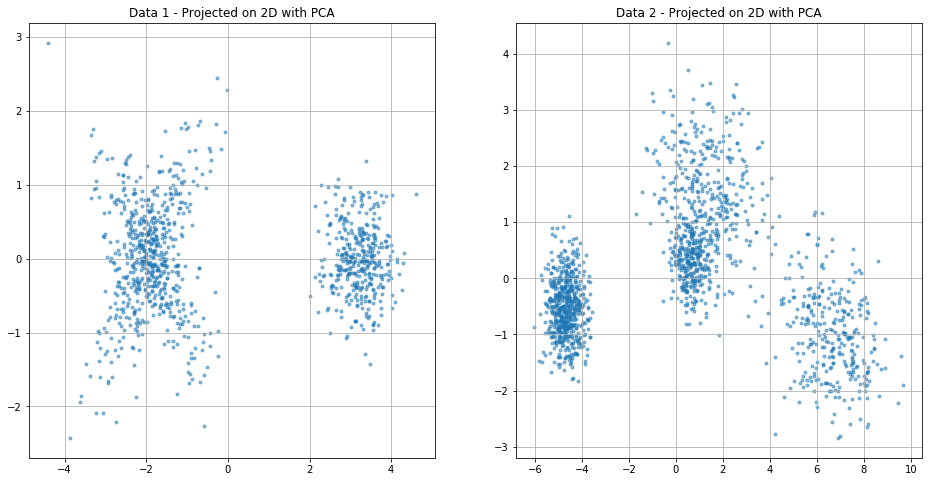

In [70]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.scatter(data_1_2d.T[0], data_1_2d.T[1], marker='.', alpha=0.5)
plt.title("Data 1 - Projected on 2D with PCA")
plt.grid()

plt.subplot(122)
plt.scatter(data_2_2d.T[0], data_2_2d.T[1], marker='.', alpha=0.5)
plt.title("Data 2 - Projected on 2D with PCA")
plt.grid()

plt.show()

In [71]:
def plot_clusters(title, data_2d, model, figsize=(8,8)):
    for label in np.unique(model.labels_):
        data_i = np.array([data_2d[j] for j in range(data_2d.shape[0]) if model.labels_[j] == label])
        plt.scatter(data_i.T[0], data_i.T[1], marker='.', label="Cluster #{}".format(label), alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.grid()

def plot_3D(title, data, model, angle, subplot=121, name='figure1'):
    fig = plt.figure(figsize=(16,8), num=name)
    ax = fig.add_subplot(subplot, projection='3d')
    for label in np.unique(model.labels_):
        data_i = np.array([data[j] for j in range(data.shape[0]) if model.labels_[j] == label])
        ax.scatter(data_i.T[0], data_i.T[1], data_i.T[2], 
                   marker='.', label="Cluster #{}".format(label), alpha=0.5)
    ax.view_init(30, angle)
    ax.set_title(title)
    ax.legend()
    ax.grid()

We fix the value of C_max, a prior, according to our observation of the data :

In [72]:
C_max = 8

### AIC

In [73]:
def do_aic(data, C_max):
    AIC_scores = []
    models = []

    start = time.time()
    for n_c in range(1, C_max+1):
        model, score = AIC(n_c, data)
        AIC_scores.append(score[0,0])
        models.append(model)
    end = time.time()

    AIC_exec_time = end-start
    AIC_best_idx = np.argmax(AIC_scores)
    AIC_best_model = models[AIC_best_idx]
    AIC_best_nc = AIC_best_model.k_
    
    return {
        'exec_time': AIC_exec_time,
        'best_model': AIC_best_model,
        'best_nb_clusters': AIC_best_nc,
        'scores': AIC_scores
    }

Apply it on our data and visualise it :

In [74]:
aic_data_1 = do_aic(data_1, C_max)
aic_data_2 = do_aic(data_2, C_max)

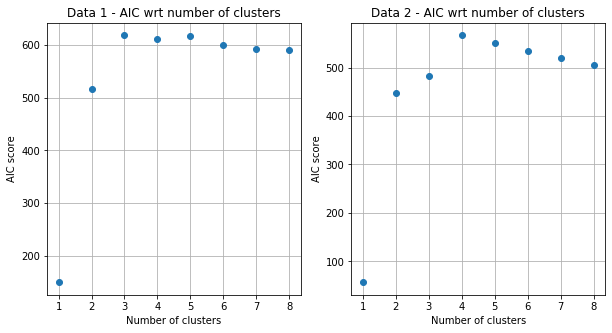

In [75]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(range(1,C_max+1), aic_data_1['scores'], linestyle='', marker='o')
plt.title('Data 1 - AIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('AIC score')
plt.grid()

plt.subplot(122)
plt.plot(range(1,C_max+1), aic_data_2['scores'], linestyle='', marker='o')
plt.title('Data 2 - AIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('AIC score')
plt.grid()

plt.show()

In [76]:
print("--- DATA 1 ---")
print("Execution time: {:.3f} s".format(aic_data_1['exec_time']))
print("Number of clusters in best model:", aic_data_1['best_nb_clusters'])
print("--- DATA 2 ---")
print("Execution time: {:.3f} s".format(aic_data_2['exec_time']))
print("Number of clusters in best model:", aic_data_2['best_nb_clusters'])

--- DATA 1 ---
Execution time: 8.929 s
Number of clusters in best model: 3
--- DATA 2 ---
Execution time: 14.548 s
Number of clusters in best model: 4


Plot the corresponding clusters :

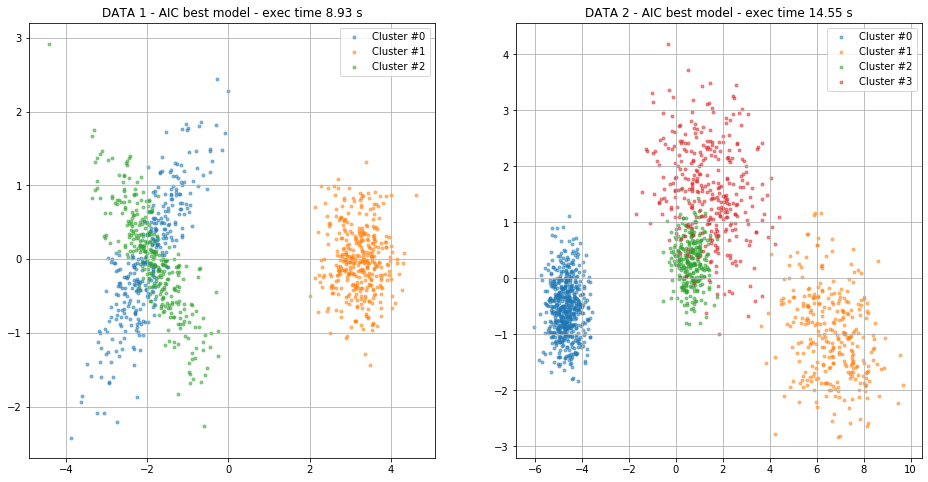

In [77]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_clusters("DATA 1 - AIC best model - exec time {:.2f} s".format(aic_data_1['exec_time']), 
              data_1_2d, aic_data_1['best_model'])
plt.subplot(122)
plot_clusters("DATA 2 - AIC best model - exec time {:.2f} s".format(aic_data_2['exec_time']), 
              data_2_2d, aic_data_2['best_model'])
plt.show()

>The method seems to work very well and yields great results. It also computes very quickly : **<20 seconds**

###### If we try to plot it in 3D :

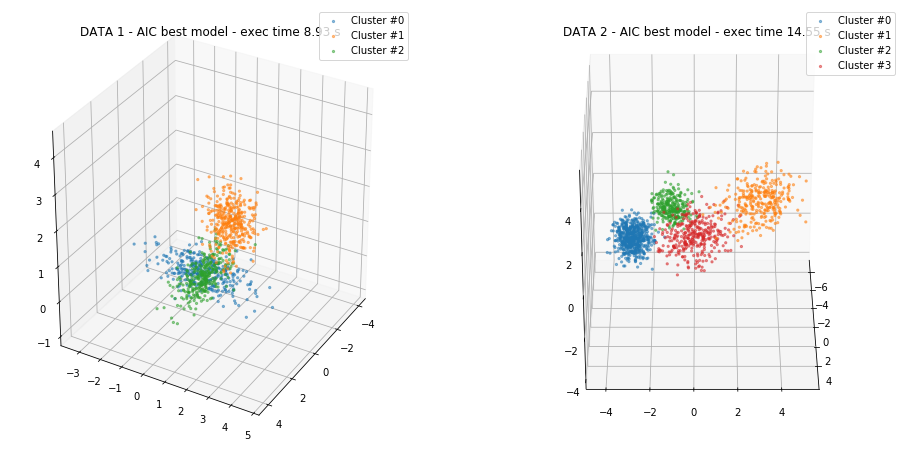

In [78]:
plot_3D("DATA 1 - AIC best model - exec time {:.2f} s".format(aic_data_1['exec_time']),
        data_1, aic_data_1['best_model'], angle=30, subplot=121)

plot_3D("DATA 2 - AIC best model - exec time {:.2f} s".format(aic_data_2['exec_time']),
        data_2, aic_data_2['best_model'], angle=0, subplot=122)

### BIC

In [79]:
def do_bic(data, C_max):
    BIC_scores = []
    models = []

    start = time.time()
    for n_c in range(1, C_max+1):
        model, score = BIC(n_c, data)
        BIC_scores.append(score[0,0])
        models.append(model)
    end = time.time()

    BIC_exec_time = end-start
    BIC_best_idx = np.argmax(BIC_scores)
    BIC_best_model = models[BIC_best_idx]
    BIC_best_nc = BIC_best_model.k_
    
    return {
        'exec_time': BIC_exec_time,
        'best_model': BIC_best_model,
        'best_nb_clusters': BIC_best_nc,
        'scores': BIC_scores
    }

Apply it on our data and visualise it :

In [80]:
bic_data_1 = do_bic(data_1, C_max)
bic_data_2 = do_bic(data_2, C_max)

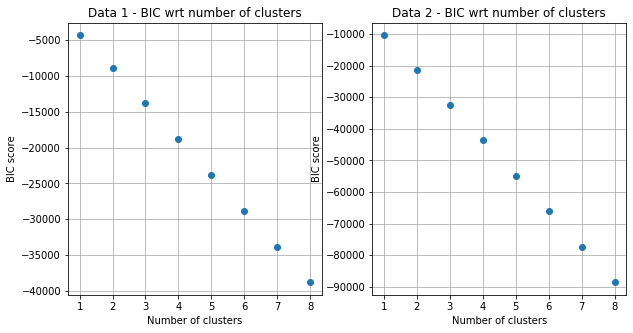

In [81]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(range(1,C_max+1), bic_data_1['scores'], linestyle='', marker='o')
plt.title('Data 1 - BIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC score')
plt.grid()

plt.subplot(122)
plt.plot(range(1,C_max+1), bic_data_2['scores'], linestyle='', marker='o')
plt.title('Data 2 - BIC wrt number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC score')
plt.grid()

plt.show()

In [82]:
print("--- DATA 1 ---")
print("Execution time: {:.3f} s".format(bic_data_1['exec_time']))
print("Number of clusters in best model:", bic_data_1['best_nb_clusters'])
print("--- DATA 2 ---")
print("Execution time: {:.3f} s".format(bic_data_2['exec_time']))
print("Number of clusters in best model:", bic_data_2['best_nb_clusters'])

--- DATA 1 ---
Execution time: 10.929 s
Number of clusters in best model: 1
--- DATA 2 ---
Execution time: 12.486 s
Number of clusters in best model: 1


Plot the corresponding clusters :

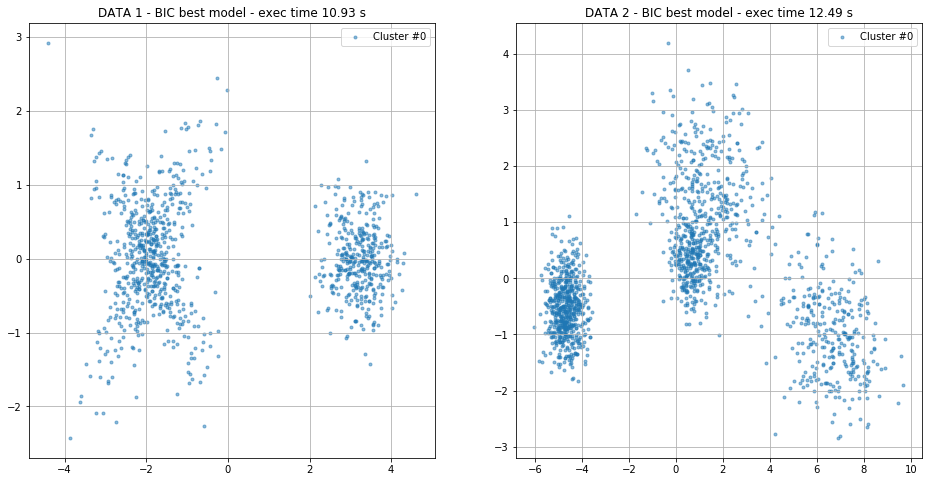

In [83]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_clusters("DATA 1 - BIC best model - exec time {:.2f} s".format(bic_data_1['exec_time']), 
              data_1_2d, 
              bic_data_1['best_model'])
plt.subplot(122)
plot_clusters("DATA 2 - BIC best model - exec time {:.2f} s".format(bic_data_2['exec_time']), 
              data_2_2d, bic_data_2['best_model'])
plt.show()

>As stated before, the BIC score seems to be too aggressive and thus always find 1 as the optimal value to maximize it... We don't bother plot it in 3D.

### Merge-based methods

#### Correlation criterion

In [84]:
def do_corr(data, C_max):
    start = time.time()
    CORR_best_model, _ = correlation_coefficients(X=data, C_max=C_max)
    end = time.time()

    CORR_exec_time = end-start
    CORR_best_nc = CORR_best_model.k_
    
    return {
        'exec_time': CORR_exec_time,
        'best_model': CORR_best_model,
        'best_nb_clusters': CORR_best_nc,
    }

Apply it on our data and visualise it :

In [85]:
corr_data_1 = do_corr(data_1, C_max)
corr_data_2 = do_corr(data_2, C_max)

In [86]:
print("--- DATA 1 ---")
print("Execution time: {:.3f} s".format(corr_data_1['exec_time']))
print("Number of clusters in best model:", corr_data_1['best_nb_clusters'])
print("--- DATA 2 ---")
print("Execution time: {:.3f} s".format(corr_data_2['exec_time']))
print("Number of clusters in best model:", corr_data_2['best_nb_clusters'])

--- DATA 1 ---
Execution time: 9.392 s
Number of clusters in best model: 3
--- DATA 2 ---
Execution time: 9.762 s
Number of clusters in best model: 4


Plot the corresponding clusters :

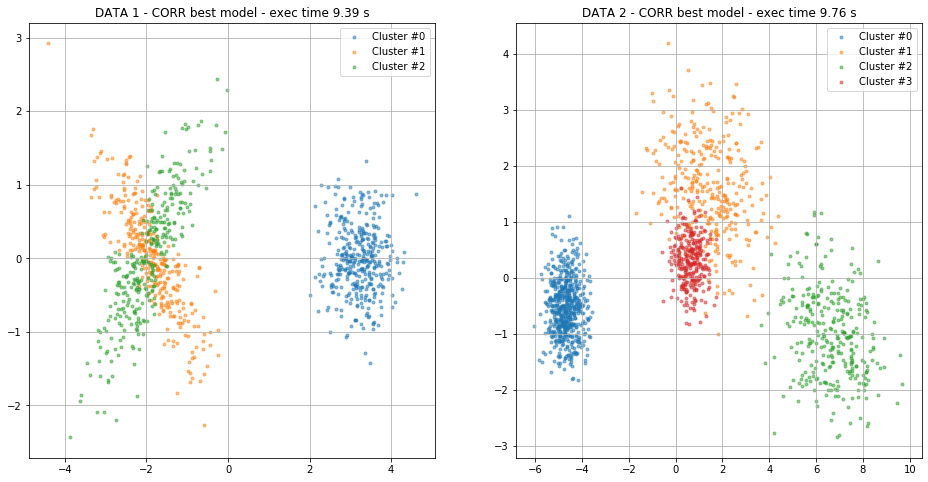

In [87]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_clusters("DATA 1 - CORR best model - exec time {:.2f} s".format(corr_data_1['exec_time']), 
              data_1_2d, 
              corr_data_1['best_model'])
plt.subplot(122)
plot_clusters("DATA 2 - CORR best model - exec time {:.2f} s".format(corr_data_2['exec_time']), 
              data_2_2d, corr_data_2['best_model'])
plt.show()

>The method seems to work very well and yields great results. It also computes quicker than the AIC : **<10 seconds**

###### If we try to plot it in 3D :

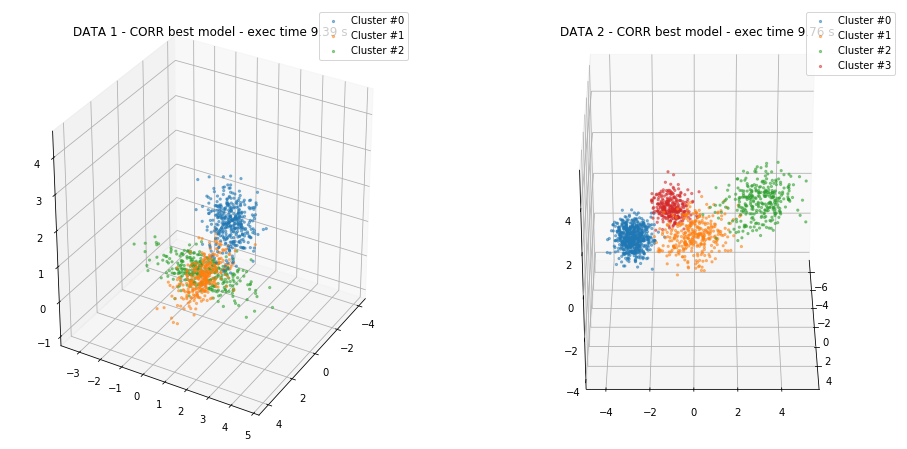

In [88]:
plot_3D("DATA 1 - CORR best model - exec time {:.2f} s".format(corr_data_1['exec_time']),
        data_1, corr_data_1['best_model'], angle=30, subplot=121)

plot_3D("DATA 2 - CORR best model - exec time {:.2f} s".format(corr_data_2['exec_time']),
        data_2, corr_data_2['best_model'], angle=0, subplot=122)

#### Likelihood criterion

In [89]:
def do_like(data, C_max):
    start = time.time()
    LIKE_best_model, _ = measuring_error(X=data, C_max=C_max)
    end = time.time()

    LIKE_exec_time = end-start
    LIKE_best_nc = LIKE_best_model.k_
    
    return {
        'exec_time': LIKE_exec_time,
        'best_model': LIKE_best_model,
        'best_nb_clusters': LIKE_best_nc,
    }

Apply it on our data and visualise it :

In [90]:
like_data_1 = do_like(data_1, C_max)
like_data_2 = do_like(data_2, C_max)

In [91]:
print("--- DATA 1 ---")
print("Execution time: {:.3f} s".format(like_data_1['exec_time']))
print("Number of clusters in best model:", like_data_1['best_nb_clusters'])
print("--- DATA 2 ---")
print("Execution time: {:.3f} s".format(like_data_2['exec_time']))
print("Number of clusters in best model:", like_data_2['best_nb_clusters'])

--- DATA 1 ---
Execution time: 108.149 s
Number of clusters in best model: 6
--- DATA 2 ---
Execution time: 225.530 s
Number of clusters in best model: 6


Plot the corresponding clusters :

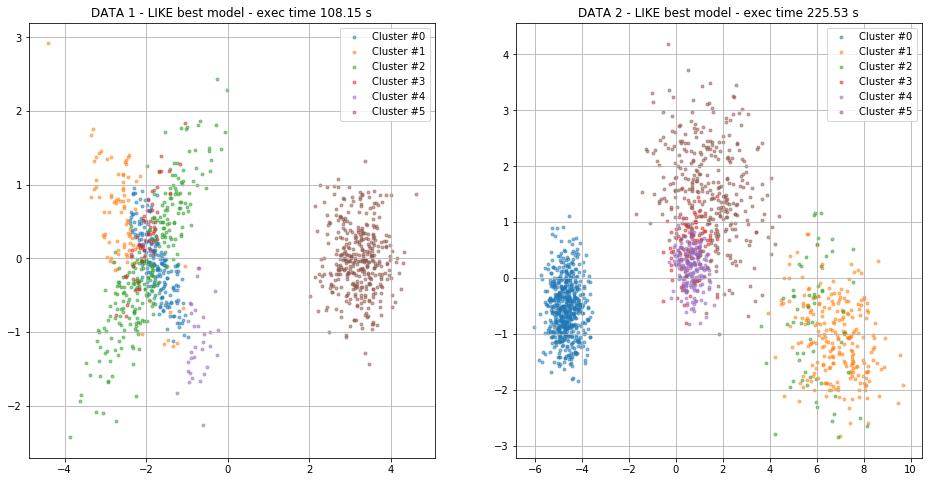

In [92]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_clusters("DATA 1 - LIKE best model - exec time {:.2f} s".format(like_data_1['exec_time']), 
              data_1_2d, like_data_1['best_model'])
plt.subplot(122)
plot_clusters("DATA 2 - LIKE best model - exec time {:.2f} s".format(like_data_2['exec_time']), 
              data_2_2d, like_data_2['best_model'])
plt.show()

>This method still doesn't work that well... and executes in **~100 to 300 seconds** which is far too high.

###### If we try to plot it in 3D :

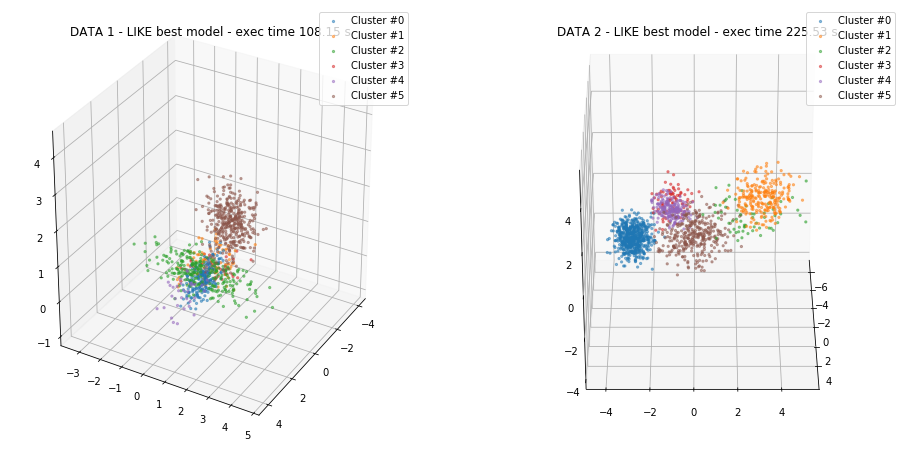

In [118]:
plot_3D("DATA 1 - LIKE best model - exec time {:.2f} s".format(like_data_1['exec_time']),
        data_1, like_data_1['best_model'], angle=30, subplot=121)

plot_3D("DATA 2 - LIKE best model - exec time {:.2f} s".format(like_data_2['exec_time']),
        data_2, like_data_2['best_model'], angle=0, subplot=122)

#### Parameters distance criterion

In [98]:
def do_compare_params(data, C_max, scoring, thresh):
    start = time.time()
    PARAM_best_model, _ = compare_params(X=data, C_max=C_max, scoring=scoring, thresh=thresh)
    end = time.time()

    PARAM_exec_time = end-start
    PARAM_best_nc = PARAM_best_model.k_
    
    return {
        'exec_time': PARAM_exec_time,
        'best_model': PARAM_best_model,
        'best_nb_clusters': PARAM_best_nc,
    }

Apply it on our data and visualise it :

In [110]:
compare_params_data_1 = do_compare_params(data_1, C_max, scoring="dist", thresh=0.05)
compare_params_data_2 = do_compare_params(data_2, C_max, scoring="dist", thresh=0.05)

old_score = 0.0007878762212428677 | new_score = 0.003707860529150377
old_score = 0.003707860529150377 | new_score = 0.007013087975235764
old_score = 0.007013087975235764 | new_score = 0.007176039606916579
old_score = 0.007176039606916579 | new_score = 0.007400055194234396
old_score = 0.007400055194234396 | new_score = 0.020303780250507584
old_score = 0.0005824954318407981 | new_score = 0.003555654619118078
old_score = 0.003555654619118078 | new_score = 0.0035630156391816656
old_score = 0.0035630156391816656 | new_score = 0.008803793149655837
old_score = 0.008803793149655837 | new_score = 0.017788154299813848
old_score = 0.017788154299813848 | new_score = 0.17775674694656216


In [111]:
print("--- DATA 1 ---")
print("Execution time: {:.3f} s".format(compare_params_data_1['exec_time']))
print("Number of clusters in best model:", compare_params_data_1['best_nb_clusters'])
print("--- DATA 2 ---")
print("Execution time: {:.3f} s".format(compare_params_data_2['exec_time']))
print("Number of clusters in best model:", compare_params_data_2['best_nb_clusters'])

--- DATA 1 ---
Execution time: 10.123 s
Number of clusters in best model: 3
--- DATA 2 ---
Execution time: 13.064 s
Number of clusters in best model: 4


Plot the corresponding clusters :

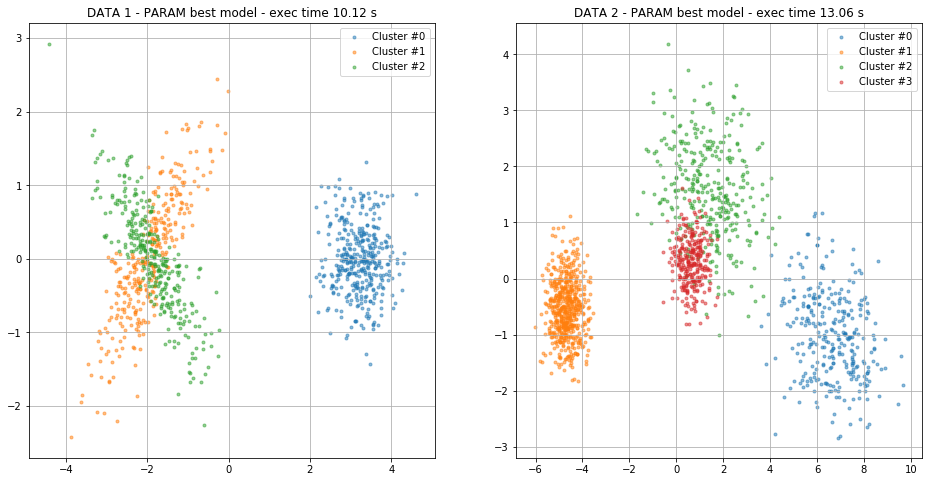

In [112]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_clusters("DATA 1 - PARAM best model - exec time {:.2f} s".format(compare_params_data_1['exec_time']), 
              data_1_2d, compare_params_data_1['best_model'])
plt.subplot(122)
plot_clusters("DATA 2 - PARAM best model - exec time {:.2f} s".format(compare_params_data_2['exec_time']), 
              data_2_2d, compare_params_data_2['best_model'])
plt.show()

>We observe that this technique is very unstable, and the quality of the results varies a lot depending on the merging criterion :
- likelihood criterion => very bad results.
- AIC score yields better results than using the likelihood criterion but still is pretty bad.
- a threshold for the distance between 2 clusters not too far from each other works very well but is highly dependent on the value of the treshold which is very hard to tune and very subjective and adds bias... This technique executes in **<15 seconds**.

###### If we try to plot it in 3D :

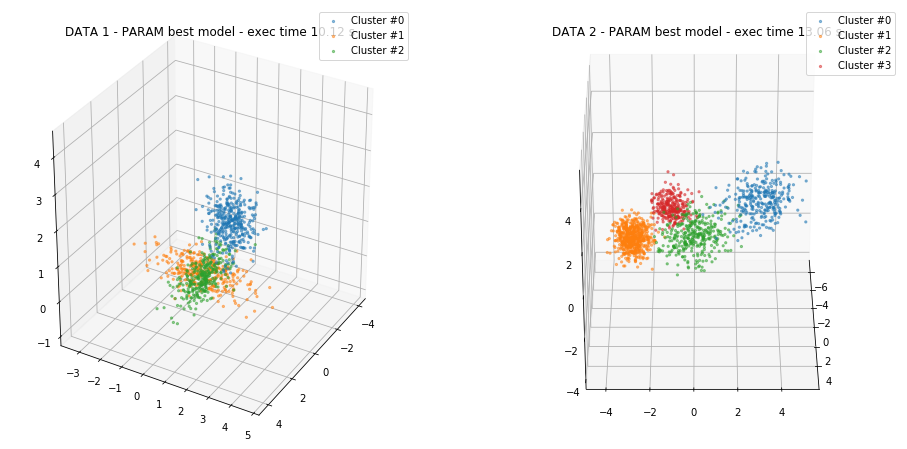

In [117]:
plot_3D("DATA 1 - PARAM best model - exec time {:.2f} s".format(compare_params_data_1['exec_time']),
        data_1, compare_params_data_1['best_model'], angle=30, subplot=121)

plot_3D("DATA 2 - PARAM best model - exec time {:.2f} s".format(compare_params_data_2['exec_time']),
        data_2, compare_params_data_2['best_model'], angle=0, subplot=122)

### Cross-validation

In this case and as stated before, we need a new score than the accuracy : we will use the log likelihood.

In [113]:
def do_scoring(est, cross_data):
    return est.log_likelihood(cross_data, est.alpha_, est.mu_, est.Sigma_)

def do_cross_val(data, C_max):
    res = {}
    for n_clusters in range(1,C_max):
        gmm = my_GMM(k=n_clusters)
        res[n_clusters] = (cross_val_score(estimator=gmm, X=data, scoring=do_scoring, cv=3),
                           gmm)
    return res

In [114]:
def do_cross_validation(X, C_max=10):
    start = time.time()
    res = do_cross_val(data=X, C_max=C_max)
    best_score = 0
    best_model = None
    for n_clusters in res.keys():
        score = np.mean(res[n_clusters][0])
        if score > best_score:
            best_score = score
            best_model = res[n_clusters][1]
    best_model.fit(X)
    end = time.time()
    
    CV_best_model = best_model

    CV_exec_time = end-start
    CV_best_nc = CV_best_model.k_
    
    return {
        'exec_time': CV_exec_time,
        'best_model': CV_best_model,
        'best_nb_clusters': CV_best_nc,
    }

Apply it on our data and visualise it :

In [115]:
cv_data_1 = do_cross_validation(data_1, C_max)
cv_data_2 = do_cross_validation(data_2, C_max)

In [116]:
print("--- DATA 1 ---")
print("Execution time: {:.3f} s".format(cv_data_1['exec_time']))
print("Number of clusters in best model:", cv_data_1['best_nb_clusters'])
print("--- DATA 2 ---")
print("Execution time: {:.3f} s".format(cv_data_2['exec_time']))
print("Number of clusters in best model:", cv_data_2['best_nb_clusters'])

--- DATA 1 ---
Execution time: 14.259 s
Number of clusters in best model: 7
--- DATA 2 ---
Execution time: 17.820 s
Number of clusters in best model: 4


Plot the corresponding clusters :

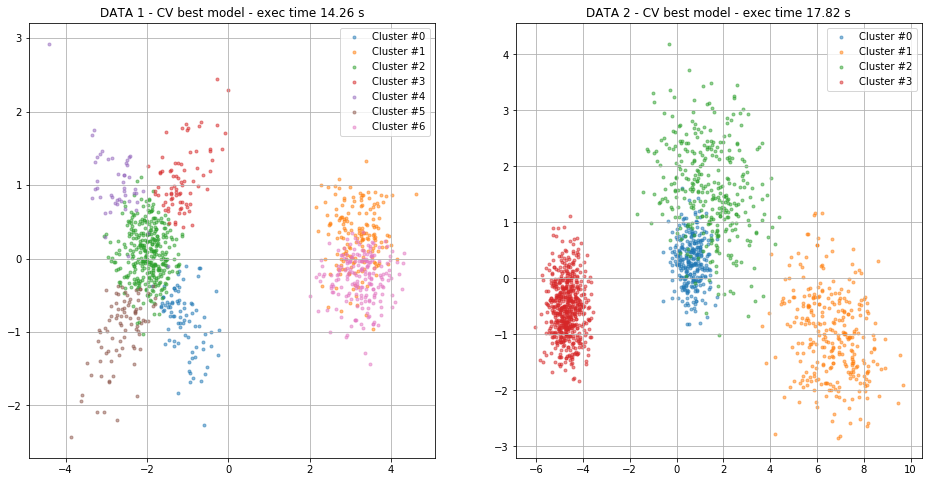

In [119]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plot_clusters("DATA 1 - CV best model - exec time {:.2f} s".format(cv_data_1['exec_time']), 
              data_1_2d, cv_data_1['best_model'])
plt.subplot(122)
plot_clusters("DATA 2 - CV best model - exec time {:.2f} s".format(cv_data_2['exec_time']), 
              data_2_2d, cv_data_2['best_model'])
plt.show()

>The method has controversial results. It yields impressive results for one dataset, but very bad ones for the other. Howerver, it executes quickly : **<20 seconds**. The likelihood score should also probably be questioned.

###### If we try to plot it in 3D :

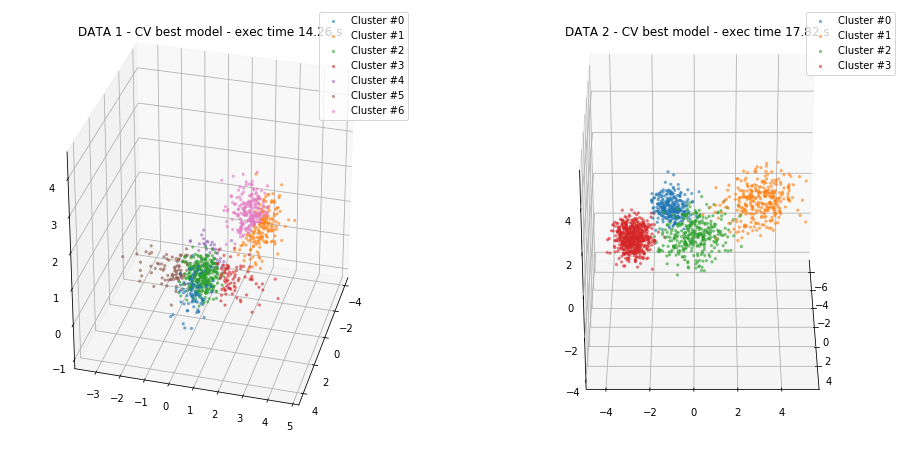

In [120]:
plot_3D("DATA 1 - CV best model - exec time {:.2f} s".format(cv_data_1['exec_time']),
        data_1, cv_data_1['best_model'], angle=15, subplot=121)

plot_3D("DATA 2 - CV best model - exec time {:.2f} s".format(cv_data_2['exec_time']),
        data_2, cv_data_2['best_model'], angle=0, subplot=122)

---

**To conclude, according to our results, the best approach to find the correct number of clusters seems to be the merging one using the correlation criterion : it executes in less than 10 seconds (quickest) and yields what seems to be the good results whithout adding any bias.**

<table style="width:40%">
<tr>
<th>Criterion</th>
<th>Number of clusters data_1(target:3)</th>
<th>Execution Time data_1</th>
<th>Number of clusters data_2(target:4)</th>
<th>Execution Time data_2</th>
</tr>

<tr>
<td>AIC</td>
<td>3</td>
<td>~9 s</td>
<td>4</td>
<td>~15 s</td>
</tr>

<tr>
<td>BIC</td>
<td>1</td>
<td>~11 s</td>
<td>1</td>
<td>~12 s</td>
</tr>

<tr>
<td>Merge correlation</td>
<td>3</td>
<td>~9 s</td>
<td>4</td>
<td>~10 s</td>
</tr>

<tr>
<td>Merge likelihood</td>
<td>6</td>
<td>~108 s</td>
<td>6</td>
<td>~225 s</td>
</tr>

<tr>
<td>Merge parameters</td>
<td>3</td>
<td>~10 s</td>
<td>4</td>
<td>~13 s</td>
</tr>

<tr>
<td>Cross Validation</td>
<td>7</td>
<td>~14 s</td>
<td>4</td>
<td>~18 s</td>
</tr>

</table>

# Application

We are going to work with the following data:

shape: (1797, 64)


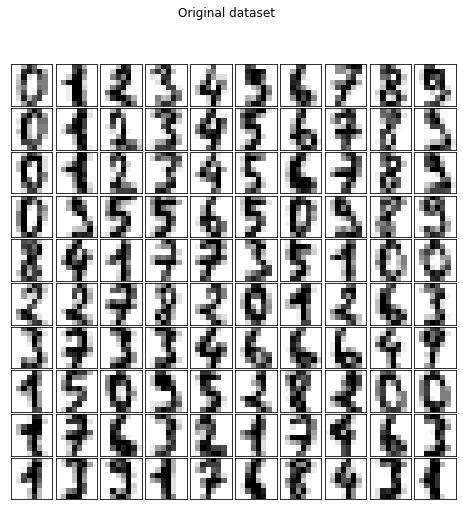

In [122]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data, title):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    fig.suptitle(title)
plot_digits(digits.data, title='Original dataset')

We model our data with our GMM class using a model order selection method to produce new synthetic handwritten numbers. We use the merging approach based on correlation coefficients as it is the one yielding the best results in the previous example. We also use a PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [123]:
digits_data = digits.data
transformer = PCA(0.99, whiten=True) # we ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(digits_data)
print("First, let's visualize the shape of our data : ", ld_data.shape)

First, let's visualize the shape of our data :  (1797, 41)


we reduce its size by a third which is already not that bad.

In [124]:
corr_digits = do_corr(ld_data, C_max=15)

print('Number of clusters found : ',corr_digits['best_nb_clusters'])

Number of clusters found :  15


> The model selection method fails to merge clusters ! That could be explained by the still high dimension of the data we're woring on. 

Let's try to reduce even more the dimensionality of the data:

In [131]:
transformer = PCA(0.9, whiten=True) # we ask it to preserve 90% of the variance in the projected data
ld_data = transformer.fit_transform(digits_data)
print("Shape of transformed data : ", ld_data.shape)

Shape of transformed data :  (1797, 21)


In [135]:
corr_digits = do_corr(ld_data, C_max=15)
#aic_digits = do_aic(ld_data, C_max=15)

print('Number of clusters found - Correlation criterion : ',corr_digits['best_nb_clusters'])
#print('Number of clusters found - AIC criterion : ',aic_digits['best_nb_clusters'])

Number of clusters found - Correlation criterion :  15


> The model still has difficutlies to find the best number of clusters but the results are still very good using this method. Let's visualize them.

Let's try to generate data using our gmm's clusters :

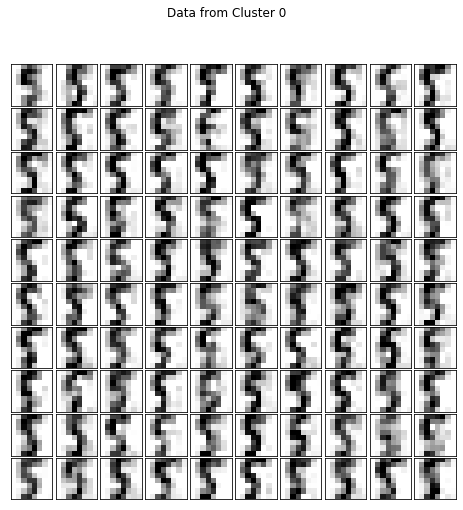

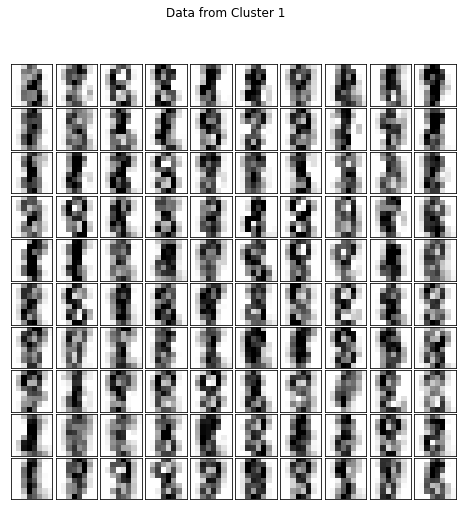

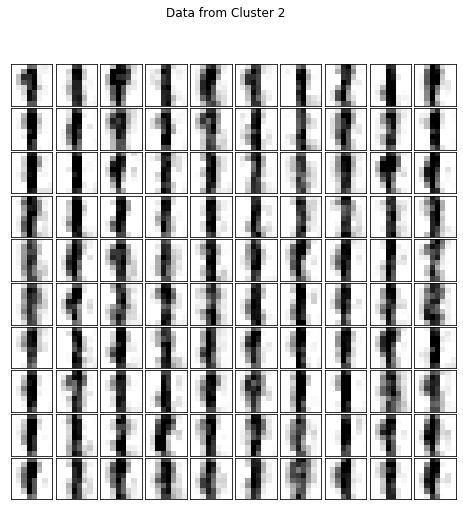

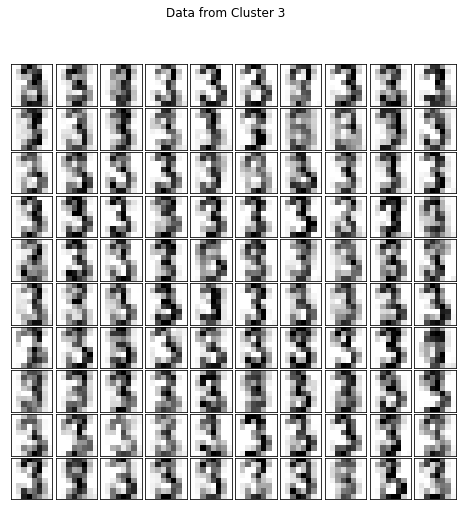

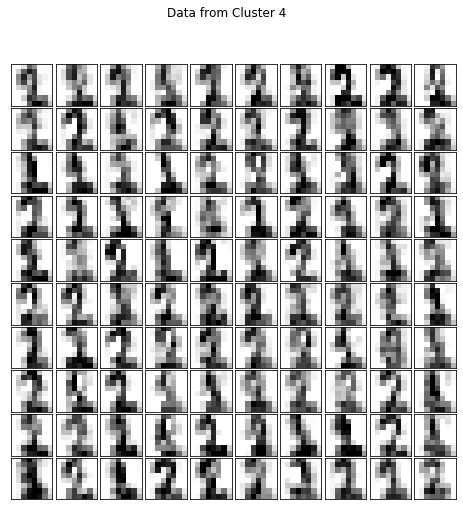

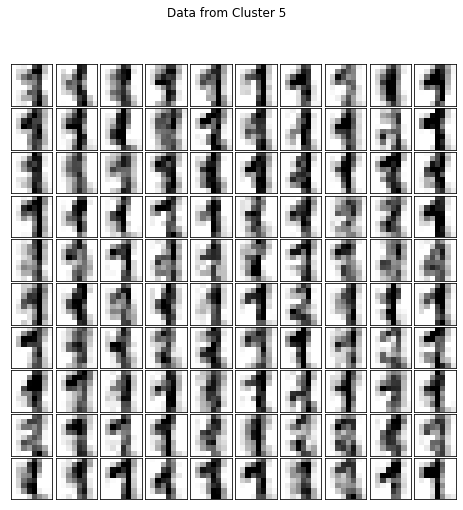

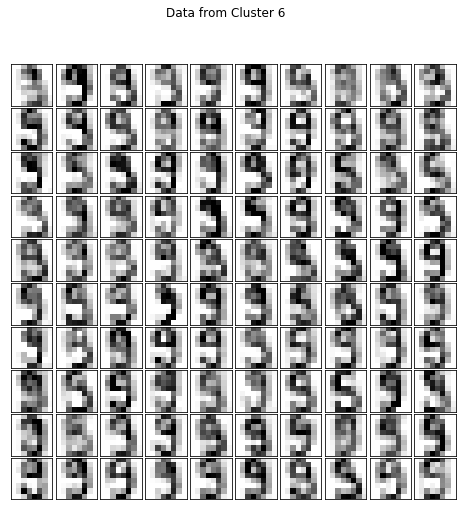

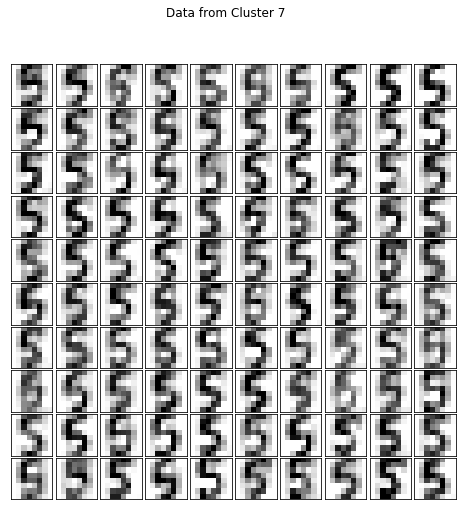

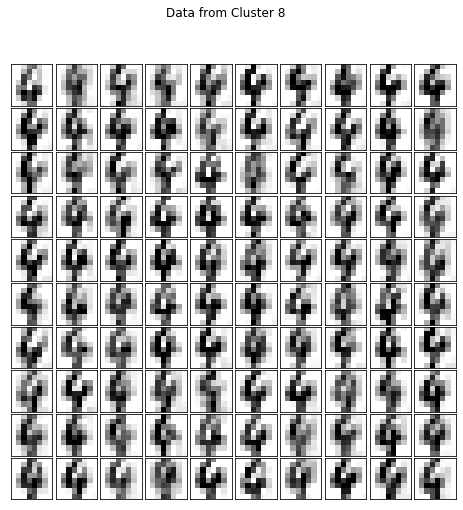

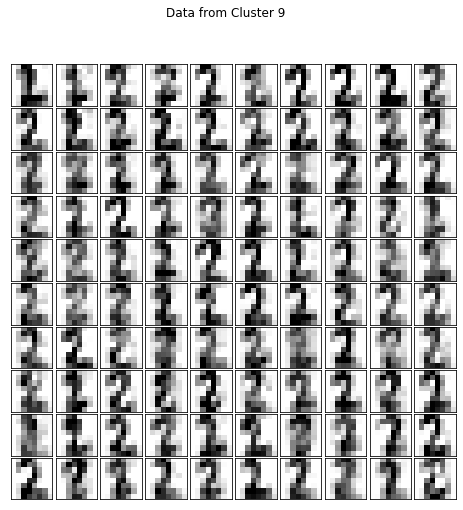

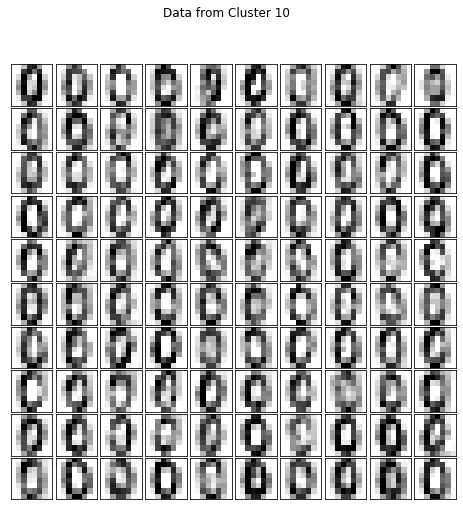

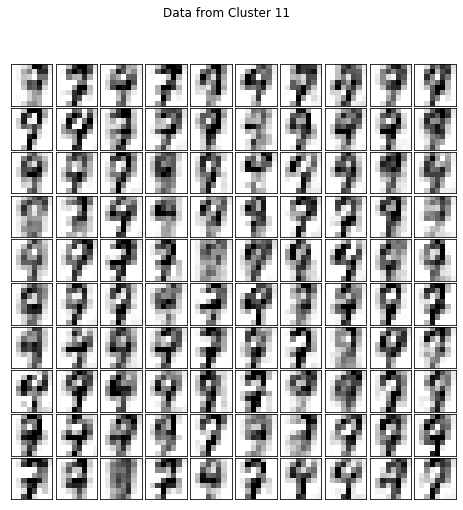

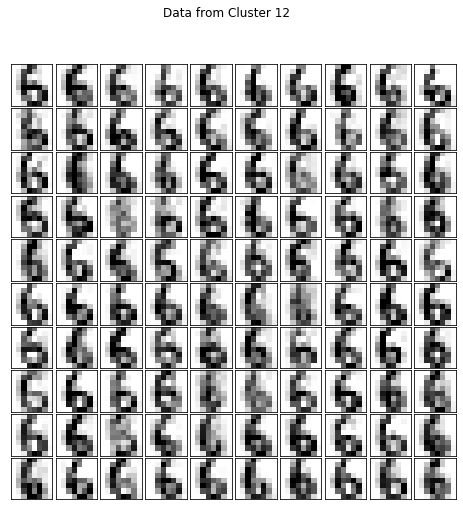

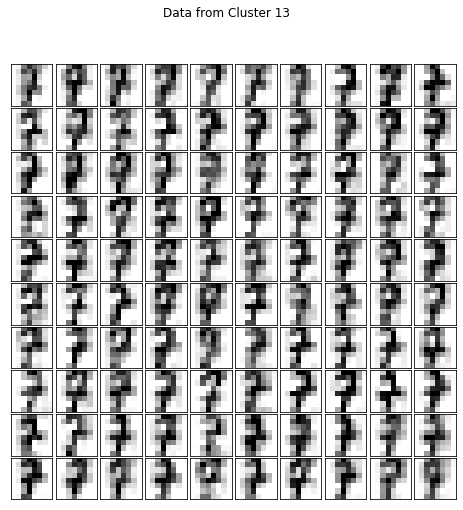

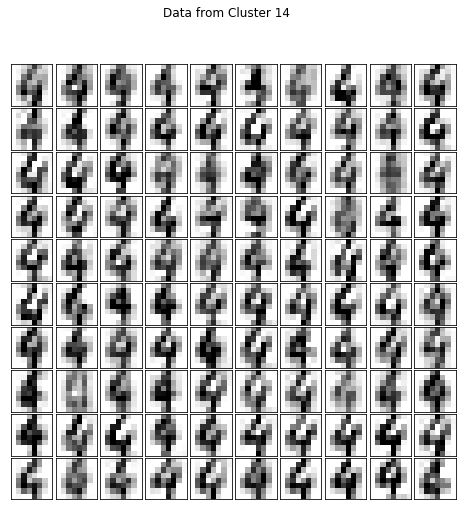

In [136]:
model = corr_digits['best_model']

generated_digits = {}

for j in range(model.k_):
    generated_digits[j] = [transformer.inverse_transform(np.random.multivariate_normal(mean=model.mu_[j], cov=model.Sigma_[j]))
                           for i in range(100)]
    plot_digits(generated_digits[j], title='Data from Cluster {}'.format(j))

>We can pretty much recognize the digits and how they are clustered ! It mixes a bit some digits but definitely get the 6s and many other. It works pretty well and we have generated data using GMMs, youhou ! However, we now all know why GANs have been invented...